# Advanced Lane finding - Project 4 of CarND Term1
This notebook implements the software pipeline to detect the road lanes for a self driving car using the advanced lane detection tools described in the module. The notebook depends on calibration and test data from the project repositery on github
https://github.com/udacity/CarND-Advanced-Lane-Lines

In [3]:
# Import all necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera calibration
Calibrate the camera using the calibration images provided in the project repositery.

In [4]:
def CalibrateMyCamera():
    # Read calibration images from camera_cal folder
    imgfiles = glob.glob('./camera_cal/calibration*.jpg')

    # Set chess board dimensions
    chess_w = 9
    chess_h = 6

    # Initialize arrays to store object points and image points
    objpoints = [] # 3D points in real world
    imgpoints = [] # 2D points in image plane

    # Prepare object points, will be same for all images
    objp = np.zeros((chess_w*chess_h, 3), np.float32)
    objp[:, :2] = np.mgrid[0:chess_w, 0:chess_h].T.reshape(-1, 2)

    # Loop through calibration images
    for imgfile in imgfiles:    
        print('Reading ' + imgfile)
        img = mpimg.imread(imgfile)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (chess_w, chess_h), None)
        if ret == True:
            # Append detected corners to imgpoints
            imgpoints.append(corners)        
            objpoints.append(objp)

    # Calibrate the camera using imgpoints and objpoints
    print('Calibrating the camera')
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

mtx, dist = CalibrateMyCamera()

Reading ./camera_cal\calibration1.jpg
Reading ./camera_cal\calibration10.jpg
Reading ./camera_cal\calibration11.jpg
Reading ./camera_cal\calibration12.jpg
Reading ./camera_cal\calibration13.jpg
Reading ./camera_cal\calibration14.jpg
Reading ./camera_cal\calibration15.jpg
Reading ./camera_cal\calibration16.jpg
Reading ./camera_cal\calibration17.jpg
Reading ./camera_cal\calibration18.jpg
Reading ./camera_cal\calibration19.jpg
Reading ./camera_cal\calibration2.jpg
Reading ./camera_cal\calibration20.jpg
Reading ./camera_cal\calibration3.jpg
Reading ./camera_cal\calibration4.jpg
Reading ./camera_cal\calibration5.jpg
Reading ./camera_cal\calibration6.jpg
Reading ./camera_cal\calibration7.jpg
Reading ./camera_cal\calibration8.jpg
Reading ./camera_cal\calibration9.jpg
Calibrating the camera


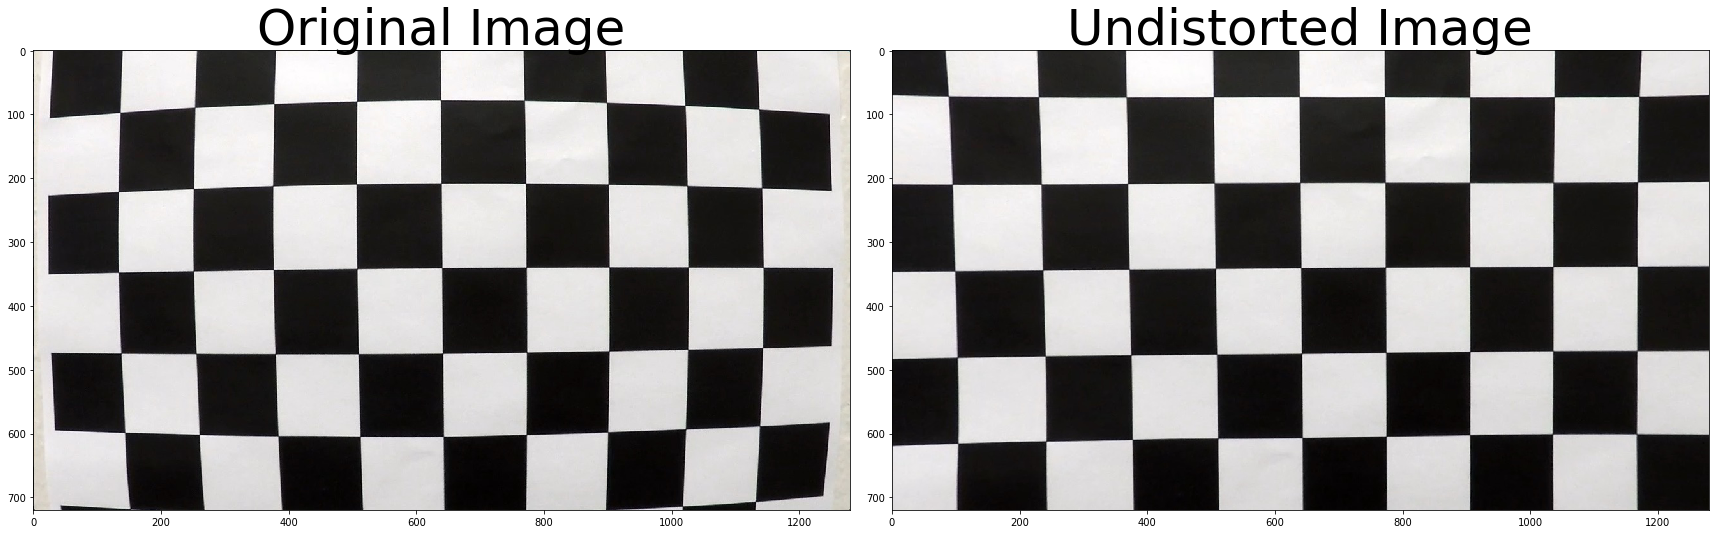

In [5]:
# Undistort a test image
test_fname = 'camera_cal/calibration1.jpg'
dist_img = mpimg.imread(test_fname)
undist_img = cv2.undistort(dist_img, mtx, dist, None, mtx)

# Display the Original (distorted) image and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(dist_img)
ax2.set_title('Undistorted Image', fontsize=50)
ax2.imshow(undist_img)

## Gradient and Color threshold

In [6]:
# Threshold functions

# Defines a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
            
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create binary output and apply lower and upper thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >=thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return binary_output
    return binary_output

# Defines a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >=mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Defines a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >=thresh[0]) & (dir_grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Defines a function that converts images to HLS space.
# then extracts the S channel and applies a threshold
def s_color_threshold(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Extract the Saturation channel
    s_channel = hls[:,:,2]
    # Threshold color channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def apply_thresholds(img, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    grad_bin = np.zeros_like(dir_binary)
    grad_bin[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    s_col_bin = s_color_threshold(img, thresh=(170, 255))
   
    # Combine the two binary thresholds
    com_bin = np.zeros_like(s_col_bin)
    com_bin[(grad_bin == 1) | (s_col_bin == 1)] = 1
    
    return com_bin

## Perspective Transformation

In [7]:
# Get perspective matrix
def GetPerspectiveMatrix():
    s_lb = (230,  700)
    s_lt = (600,  450)
    s_rt = (690,  450)
    s_rb = (1080, 700)
    s_pts = [s_lb, s_lt, s_rt, s_rb]
    src = np.float32(s_pts)
        
        
    d_lb = (250,  700)
    d_lt = (250,    0) 
    d_rt = (1000,   0)
    d_rb = (1000, 700)
    d_pts = [d_lb, d_lt, d_rt, d_rb]
    dst = np.float32(d_pts)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv
    

# Perspective transformation
def warp(img, plot_pts=0):    
    img_size = (img.shape[1], img.shape[0])
    s_lb = (230,  700)
    s_lt = (600,  450)
    s_rt = (690,  450)
    s_rb = (1080, 700)
    s_pts = [s_lb, s_lt, s_rt, s_rb]
    src = np.float32(s_pts)
        
        
    d_lb = (250,  700)
    d_lt = (250,    0) 
    d_rt = (1000,   0)
    d_rb = (1000, 700)
    d_pts = [d_lb, d_lt, d_rt, d_rb]
    dst = np.float32(d_pts)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # If plot_pts is set, draw the original and wrapped images
    if plot_pts == True:
        color = [255, 0, 0]
        thickness = 5
        
        img_copy = np.copy(img)
        cv2.line(img_copy, s_lb, s_lt, color, thickness)
        cv2.line(img_copy, s_lt, s_rt, color, thickness)
        cv2.line(img_copy, s_rt, s_rb, color, thickness)
        cv2.line(img_copy, s_rb, s_lb, color, thickness)
        
        warped_copy = np.copy(warped)
        cv2.line(warped_copy, d_lb, d_lt, color, thickness)
        cv2.line(warped_copy, d_lt, d_rt, color, thickness)
        cv2.line(warped_copy, d_rt, d_rb, color, thickness)
        cv2.line(warped_copy, d_rb, d_lb, color, thickness)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.set_title('Original Image with source points', fontsize=20)
        ax1.imshow(img_copy)
        ax2.set_title('Unwarped image with destination points.', fontsize=20)
        ax2.imshow(warped_copy)
        
    return warped

In [8]:
# Pipeline
# Does following processing steps
# Undistort -> apply gradient and color threshold and applies perspective transform
# then returns a binary image
def pipeline(dist_img):
    # Undistort the image
    image = cv2.undistort(dist_image, mtx, dist, None, mtx)
    # Apply gradient and color thresholds
    com_bin = apply_thresholds(image, ksize=3)
    com_bin_warped = warp(com_bin)
    return com_bin_warped

## Lane detection

In [9]:
# Defines the function to locate the lanes using histogram
# and then fit polynomials for left and right lanes
def polyfit_lanes(warp_image):
    height = warp_image.shape[0];
    width = warp_image.shape[1];
    
    # Calculate histogrm of bottom half of image along columns
    histogram = np.sum(warp_image[np.int(height/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(height/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warp_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window+1)*window_height
        win_y_high = height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # return the co-effs
    return left_fit, right_fit

In [18]:
# Defines a class to describe the characteristics of each line detection
class Line():
        # Reset
    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Minimum curvature allowed for a valid lane
        self.min_allowed_curvature = 587

    # Constructor
    def __init__(self):
        self.reset()
        
    # Do sanity check
    def sanity_check(self):              
        if self.detected == False:
            # Nothing to do. There is no line detected.
            return False
        
        # Check if radius of curvature is reasonable
        if self.radius_of_curvature <= self.min_allowed_curvature:
            return False
        
        # Line seems OK
        return True

left_lane = Line()
right_lane = Line()

In [10]:
def process_image(dist_image):
    # Undistort the image
    image = cv2.undistort(dist_image, mtx, dist, None, mtx)
    # Apply gradient and color thresholds
    com_bin = apply_thresholds(image, ksize=3)
    warped_image = warp(com_bin)

    if ((left_lane.detected == False) or (right_lane.detected == False)):
        left_fit, right_fit = polyfit_lanes(warped_image)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    left_roc = np.int(left_curverad)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    right_roc = np.int(right_curverad)
    
    # Updates class
    left_lane.radius_of_curvature = left_roc
    right_lane.radius_of_curvature = right_roc
    
    # Create an image to draw the lines on
    M, Minv = GetPerspectiveMatrix()

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Add some information to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp,'RoC: L:'+str(left_roc)+' R:'+str(right_roc),(10,100), font, 1,(255,255,0),3,cv2.LINE_AA)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    # Return the processed image
    return result

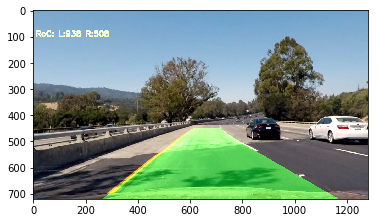

In [14]:
# Let's test with test images
dist_image = mpimg.imread('test_images/test4.jpg')
out_image = process_image(dist_image)
plt.imshow(out_image)

In [16]:
# Let's try with videos
clip1 = VideoFileClip("project_video.mp4")
subclip = clip1.subclip(0, 2)
processed_clip = subclip.fl_image(process_image)
output_video = 'marked_project_video.mp4'
%time processed_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video marked_project_video.mp4
[MoviePy] Writing video marked_project_video.mp4


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 50/51 [00:12<00:00,  4.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: marked_project_video.mp4 

Wall time: 13.8 s


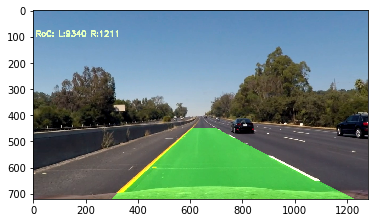

In [9]:
left_lane = Line()
right_lane = Line()

myclip = VideoFileClip("project_video.mp4")
for frame in myclip.iter_frames():
    # Undistort the image
    image = cv2.undistort(frame, mtx, dist, None, mtx)
    # Apply gradient and color thresholds
    com_bin = apply_thresholds(image, ksize=3)
    warped_image = warp(com_bin)

    left_fit, right_fit = polyfit_lanes(warped_image)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    left_roc = np.int(left_curverad)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    right_roc = np.int(right_curverad)

    # Create an image to draw the lines on
    M, Minv = GetPerspectiveMatrix()

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Add some information to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp,'RoC: L:'+str(left_roc)+' R:'+str(right_roc),(10,100), font, 1,(255,255,0),3,cv2.LINE_AA)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    plt.imshow(result)
    